In [1]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from mpl_toolkits import mplot3d
from matplotlib import cm
from matplotlib.ticker import LinearLocator

**Loading and Describing Data**

In [2]:
# load data
data = "/kaggle/input/house-price-prediction/train.csv"
df = pd.read_csv(data)

# shows a preview of first 6 rows of data
df.head(6)

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5
5,Owner,0,0,3,BHK,1250.000000,1,1,"South Chittoor,Kochi",10.033280,76.282571,42.0


**Description**

This dataset contains information about houses and their prices in India.

**Column Descriptions**

* **UNDER_CONSTRUCTION**: Under construction or not (0 or 1)
* **RERA**: Rera-approved or not (0 or 1)
* **BHK_NO**: Number of bedrooms
* **BHK_OR_RK**: Configuration of the house. BKH stands for "Bedroom Hall Kitchen" while RK stands for "Room Kitchen"
* **SQUARE_FT**: Area of the house in square feet
* **READY_TO_MOVE**: Property marked as ready to move or not (0 or 1)
* **RESALE**: Property marked as resale or not (0 or 1)
* **ADDRESS**: the property's location (town)
* **LONGITUDE**: Longitude of the property
* **LATITUDE**: Latitude of the property
* **TARGET(PRICE_IN_LACS)**: The prices are in "lacs" (100k).

In [3]:
df.describe()

,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
count,29451.000000,29451.000000,29451.000000,2.945100e+04,29451.000000,29451.000000,29451.000000,29451.000000,29451.000000
mean,0.179756,0.317918,2.392279,1.980217e+04,0.820244,0.929578,21.300255,76.837695,142.898746
std,0.383991,0.465675,0.879091,1.901335e+06,0.383991,0.255861,6.205306,10.557747,656.880713
min,0.000000,0.000000,1.000000,3.000000e+00,0.000000,0.000000,-37.713008,-121.761248,0.250000
25%,0.000000,0.000000,2.000000,9.000211e+02,1.000000,1.000000,18.452663,73.798100,38.000000
50%,0.000000,0.000000,2.000000,1.175057e+03,1.000000,1.000000,20.750000,77.324137,62.000000
75%,0.000000,1.000000,3.000000,1.550688e+03,1.000000,1.000000,26.900926,77.828740,100.000000
max,1.000000,1.000000,20.000000,2.545455e+08,1.000000,1.000000,59.912884,152.962676,30000.000000


This is a dataset of around 29k houses. Most of the houses aren't under construction, have 2 bedrooms, and are ready to move. The houses have an average of 20k square ft, and have a mean price of 143 lacs.

It's also apparent from the table that there may be some outliers, since the max values for number of rooms, square ft, and house prices are all significantly higher than the mean, and even the 75 percentile.



**Clean Data**

Before making the linear regression models, the data must be cleaned up.

**Check for Missing Values**

Missing values will interfere with the plotting, when the x and y columns have a different number of values, or the values don't match up.

In [4]:
df.columns[df.isnull().any()]

df.isnull().sum()

POSTED_BY                0
UNDER_CONSTRUCTION       0
RERA                     0
BHK_NO.                  0
BHK_OR_RK                0
SQUARE_FT                0
READY_TO_MOVE            0
RESALE                   0
ADDRESS                  0
LONGITUDE                0
LATITUDE                 0
TARGET(PRICE_IN_LACS)    0
dtype: int64

**Check for Outliers**

If there are outliers in the data, they will affect the linear regression more than intended. Therefore, the outliers need to be found and cleaned up.

This can be done by first finding the numeric columns, and then making box plots to visualize them individually. That will provide a visual of the outliers, which will be outside of the box and whiskers.

In [5]:
data = df.copy()
data = data.select_dtypes(include=["float64","int64"])
data.head()

,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,0,0,2,1300.236407,1,1,12.969910,77.597960,55.0
1,0,0,2,1275.000000,1,1,12.274538,76.644605,51.0
2,0,0,2,933.159722,1,1,12.778033,77.632191,43.0
3,0,1,2,929.921143,1,1,28.642300,77.344500,62.5
4,1,0,2,999.009247,0,1,22.592200,88.484911,60.5


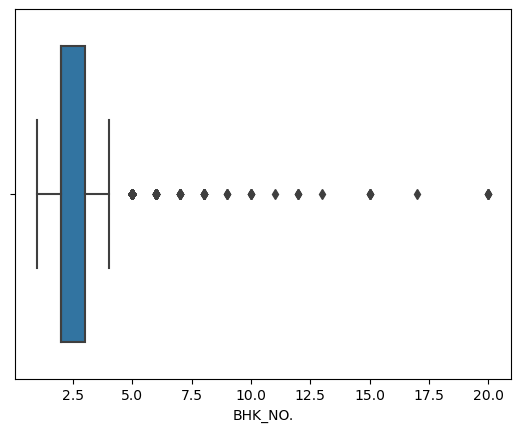

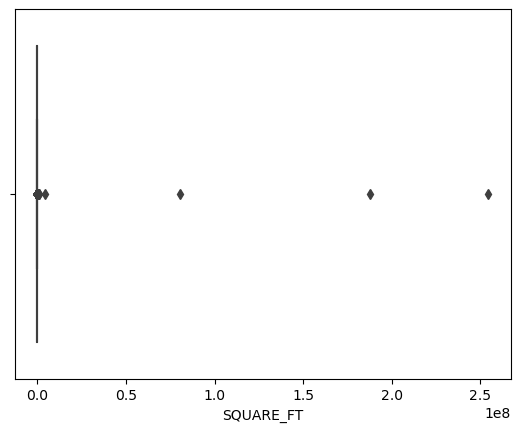

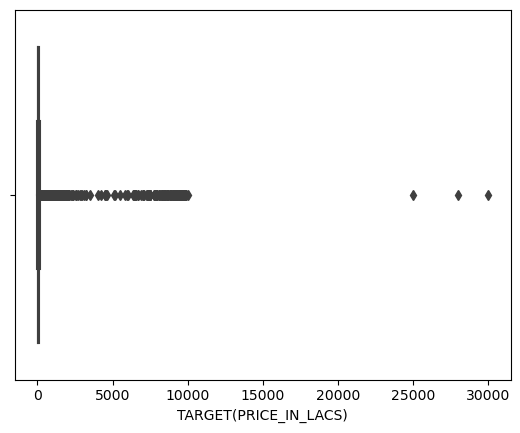

In [6]:
column_list = ['BHK_NO.', 'SQUARE_FT','TARGET(PRICE_IN_LACS)']
for col in column_list:
    sns.boxplot(x = data[col])
    plt.xlabel(col)
    plt.show()

In [7]:
# Removing outliers
# get the lists of the columns
sqft = list(df['SQUARE_FT'])
rooms = list(df['BHK_NO.'])
price = list(df['TARGET(PRICE_IN_LACS)'])

# get rid of the highest values in sqft and prices, since that's where the outliers are
new_sqft = sqft
for i in range(200):
    x = sqft.index(sorted(sqft)[-1])
    del new_sqft[x] # https://stackoverflow.com/questions/627435/how-to-remove-an-element-from-a-list-by-index
    del rooms[x]
    del price[x]
new_price = price
for i in range(100):
    y = price.index(sorted(price)[-1])
    del new_sqft[y]
    del rooms[y]
    del new_price[y]

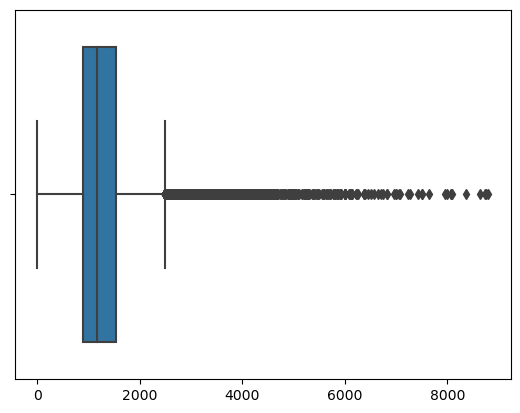

In [8]:
sns.boxplot(x=new_sqft)
plt.show()

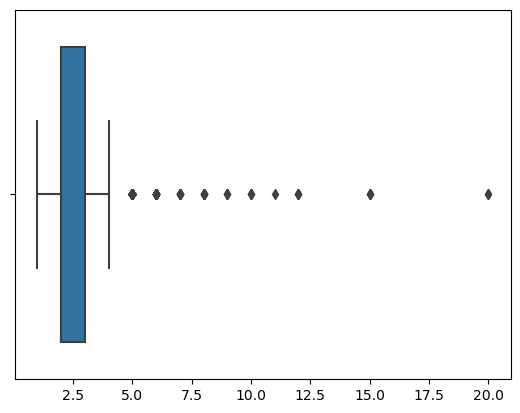

In [9]:
sns.boxplot(x=rooms)
plt.show()

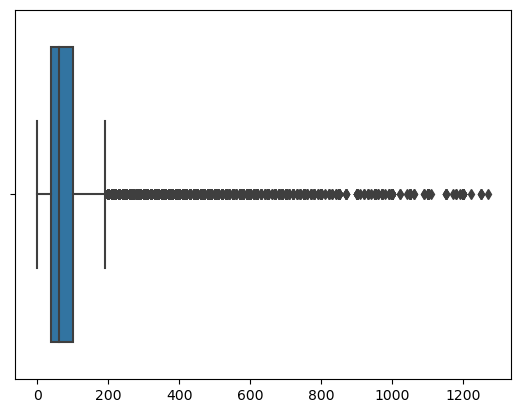

In [10]:
sns.boxplot(x=price)
plt.show()

**Linear Regression**

Linear regressions can be used to model our data for predictions. It takes two columns of the data, graphs it, and makes a line of best fit in the form of  y=mx+b
 . It can also show the relationship between two different columns of the data, as well as the trend.

**Total Area vs. House Price**

A positive correlation between the total area of the house and the pricing is expected.

**With Outliers**

For comparison, both the models with and without outliers will be graphed.

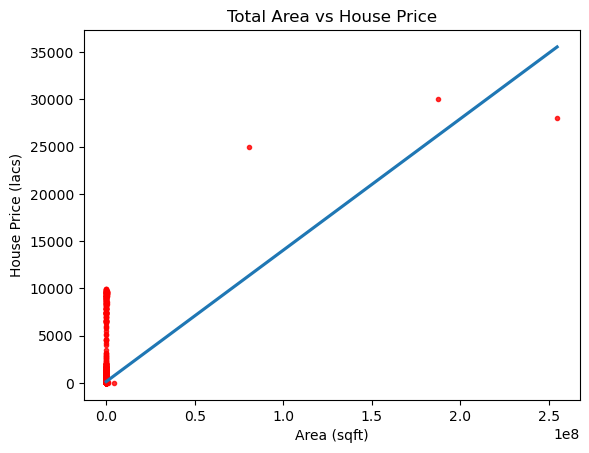

intercept (m): 139.71963280033685
coef (b): [0.00012774]
RScore (r^2): 0.1090767624511143
MAE: 135.84630921926123


In [11]:
g = sns.regplot(x=df['SQUARE_FT'],y=df["TARGET(PRICE_IN_LACS)"],ci=None,scatter_kws = {'color':'r','s':9})
g.set_title("Total Area vs House Price")
g.set_ylabel("House Price (lacs)")
g.set_xlabel('Area (sqft)')
plt.show()

X = df['SQUARE_FT'].values.reshape(-1,1)
y = df['TARGET(PRICE_IN_LACS)']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)
lin_reg = LinearRegression()
model = lin_reg.fit(X_train,y_train)
predictions = lin_reg.predict(X_test)

print("intercept (m):",model.intercept_)
print("coef (b):",model.coef_)
print("RScore (r^2):",model.score(X_test,y_test))
print("MAE:",metrics.mean_absolute_error(y_test, predictions))

**Without Outliers**

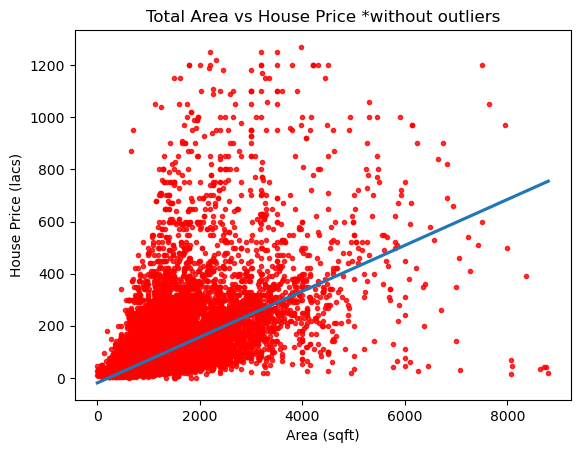

intercept (m): -20.261967245747
coef (b): [0.08845136]
RScore (r^2): 0.28149497751399666
MAE: 52.91762692339938


In [12]:
g = sns.regplot(x=new_sqft,y=new_price,ci=None,scatter_kws = {'color':'r','s':9})
g.set_title("Total Area vs House Price *without outliers")
g.set_ylabel("House Price (lacs)")
g.set_xlabel('Area (sqft)')
plt.show()

# Linear Regression
X = np.array(new_sqft).reshape(-1, 1) # https://stackoverflow.com/questions/6614261/how-can-i-turn-a-flat-list-into-a-2d-array-in-python
y = new_price
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)
lin_reg = LinearRegression()
model = lin_reg.fit(X_train,y_train)
predictions = lin_reg.predict(X_test)

print("intercept (m):",model.intercept_)
print("coef (b):",model.coef_)
print("RScore (r^2):",model.score(X_test,y_test))
print("MAE:",metrics.mean_absolute_error(y_test, predictions))

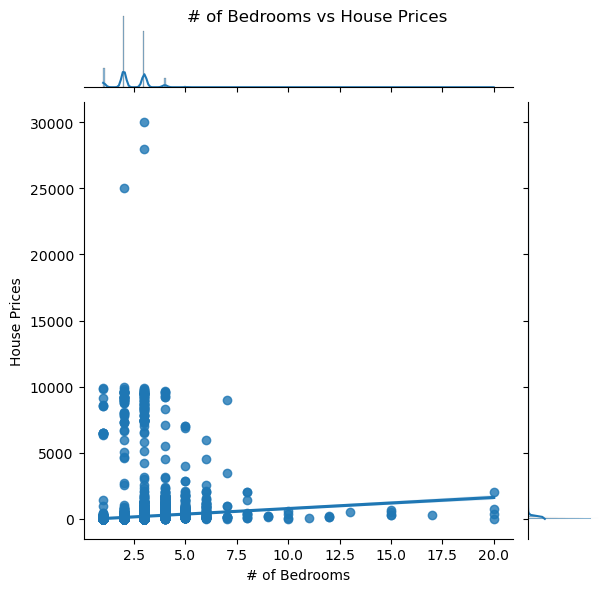

In [13]:
g = sns.jointplot(x="BHK_NO.", y="TARGET(PRICE_IN_LACS)", data=df, kind="reg")
g.fig.suptitle("# of Bedrooms vs House Prices")
g.set_axis_labels('# of Bedrooms', 'House Prices')

plt.show()


In [14]:
X = df['BHK_NO.'].values.reshape(-1,1)
y = df['TARGET(PRICE_IN_LACS)']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)
lin_reg = LinearRegression()
model = lin_reg.fit(X_train,y_train)
predictions = lin_reg.predict(X_test)

print("intercept (m):",model.intercept_)
print("coef (b):",model.coef_)
print("RScore (r^2):",model.score(X_test,y_test))
print("MAE:",metrics.mean_absolute_error(y_test, predictions))

intercept (m): -62.83149395027604
coef (b): [86.00946026]
RScore (r^2): 0.011226763744550783
MAE: 131.08673718659676


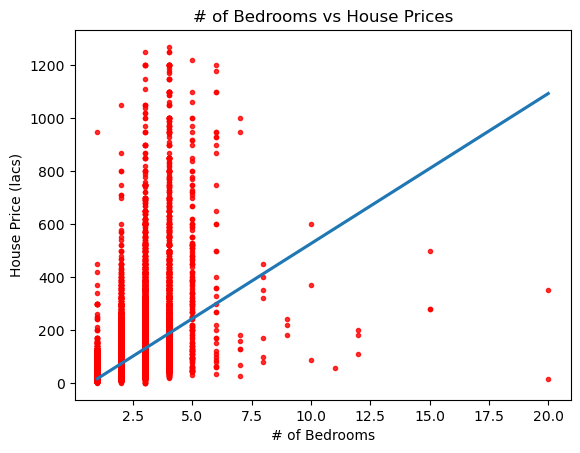

intercept (m): -46.41086673847708
coef (b): [59.26236206]
RScore (r^2): 0.16529551378117202
MAE: 59.61255293112337


In [15]:
# Graph
g = sns.regplot(x=rooms,y=new_price,ci=None,scatter_kws = {'color':'r','s':9})
g.set_title("# of Bedrooms vs House Prices")
g.set_ylabel("House Price (lacs)")
g.set_xlabel('# of Bedrooms')
plt.show()

# Linear Regression
# (https://stackoverflow.com/questions/6614261/how-can-i-turn-a-flat-list-into-a-2d-array-in-python)
X = np.array(rooms).reshape(-1, 1)
y = new_price
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)
lin_reg = LinearRegression()
model = lin_reg.fit(X_train,y_train)
predictions = lin_reg.predict(X_test)

print("intercept (m):",model.intercept_)
print("coef (b):",model.coef_)
print("RScore (r^2):",model.score(X_test,y_test))
print("MAE:",metrics.mean_absolute_error(y_test, predictions))

In [16]:
X = df[['BHK_NO.','SQUARE_FT']]
y = df['TARGET(PRICE_IN_LACS)']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=5, random_state=1)
lin_reg = LinearRegression()
model = lin_reg.fit(X_train,y_train)
predictions = lin_reg.predict(X_test)

print("intercept (m):",model.intercept_)
print("coef (b) of each independent variable:",model.coef_)
print("RScore (r^2):",model.score(X_test,y_test))
print("MAE:",metrics.mean_absolute_error(y_test, predictions))

intercept (m): -56.551605004438045
coef (b) of each independent variable: [8.21304752e+01 1.38912846e-04]
RScore (r^2): -0.20864616109671474
MAE: 1425.7260374382886


**Without Outliers**

In [17]:
X = np.array([np.array(rooms),np.array(new_sqft)])
y = np.array(new_price)
X = X.transpose() # https://datascience.stackexchange.com/questions/20199/train-test-split-error-found-input-variables-with-inconsistent-numbers-of-sam
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.5, random_state=1)
lin_reg = LinearRegression()
model = lin_reg.fit(X_train,y_train)
predictions = lin_reg.predict(X_test)

print("intercept (m):",model.intercept_)
print("coef (b) of each independent variable:",model.coef_)
print("RScore (r^2):",model.score(X_test,y_test))
print("MAE:",metrics.mean_absolute_error(y_test, predictions))

intercept (m): -33.32610887709838
coef (b) of each independent variable: [11.52397048  0.07736261]
RScore (r^2): 0.28091600933065575
MAE: 53.744756754052716


**Analysis**

Evidently, the model without outliers has a much smaller mean absolute error, and is much closer to the actual data. Nevertheless, it's still very inaccurate, with only a 0.281 r-value.

In comparison with the simple linear regressions, the multiple linear regression is more accurate than the "Bedrooms vs House Price" linreg, and very close to the "Area vs House Price" model (which is barely more accurate than this one by a R score of 0.0005). This may be because of the lower correlation of bedrooms to house price, so that when the less correlated bedrooms column was used with the higher correlated sqare feet column, the model became less correlated than just the square feet column on its own.

**Conclusion**

Each of the columns had an extremely low positive correlation with the house prices, with the highest correlated model being "Area vs House Price," with an R-score of 0.281, and a MAE of 52.918. This shows that house prices are not determined by the number of bedrooms, the total area of the house, or a combination of the two. It could be that the prices are more correlated with one or more of the columns that weren't modeled, like longitude and latitude, which would be worth modeling if time permitted.

Some bias may be present in the process of removing the outliers. The amount of outliers were too large for all of them to be removed, so some decisions based visually on the box plots were made for how many outliers to remove. Since the Square Root column had the most number of outliers, more data points that were outliers in that column were removed from the dataset. Meanwhile, the bedrooms column was not as affected by its outliers, so none of the outliers from that column were removed from the dataset. It could be because of this that the model involving the square root column had a higher correlation than the model with the bedrooms column.

In addition, the exact source of this dataset is rather unknown and unverified, leading to the possiblility of bias in the collection of the data itself.